## Loading dataset

In [139]:
import numpy as np
from matplotlib.image import imread, imsave
import os

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Load all data
image_dir = "images"
mask_dir = "masks"

In [71]:
from glob import glob

In [79]:
import cv2

In [99]:
images = []
masks = []
for img_fn, mask_fn in zip(glob('images/*.png')[:100], glob('masks/*.png')[:100]):
    img = cv2.imread(img_fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_fn, cv2.IMREAD_GRAYSCALE)
    
    images.append(img)
    masks.append(mask)

images = np.array(images)  # Shape: (100, 240, 240, 3)
masks = np.array(masks)    # Shape: (100, 240, 240)

In [100]:
masks = np.round(masks/128).astype(int)

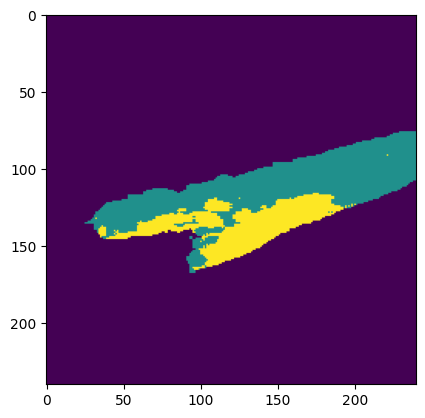

In [141]:
plt.imshow(masks[0]);

## Exploratory Data Analysis

### Basic Statistics

In [102]:
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Unique mask values: {np.unique(masks)}")

# Pixel distribution
background_pct = np.mean(masks == 0) * 100
healthy_pct = np.mean(masks == 1) * 100
diseased_pct = np.mean(masks == 2) * 100

print(f"Background: {background_pct:.1f}%")
print(f"Healthy leaf: {healthy_pct:.1f}%")
print(f"Diseased leaf: {diseased_pct:.1f}%")

# Per-image disease percentage
disease_percentages = []
for mask in masks:
    leaf_pixels = mask[mask != 0]
    if len(leaf_pixels) > 0:
        disease_pct = np.mean(leaf_pixels == 2) * 100
        disease_percentages.append(disease_pct)

print(f"Avg disease on leaf area: {np.mean(disease_percentages):.1f}%")

Images shape: (100, 240, 240, 3)
Masks shape: (100, 240, 240)
Unique mask values: [0 1 2]
Background: 74.0%
Healthy leaf: 18.1%
Diseased leaf: 8.0%
Avg disease on leaf area: 29.7%


In [103]:
import matplotlib.pyplot as plt

In [104]:
masks.shape

(100, 240, 240)

### Visual Inspection

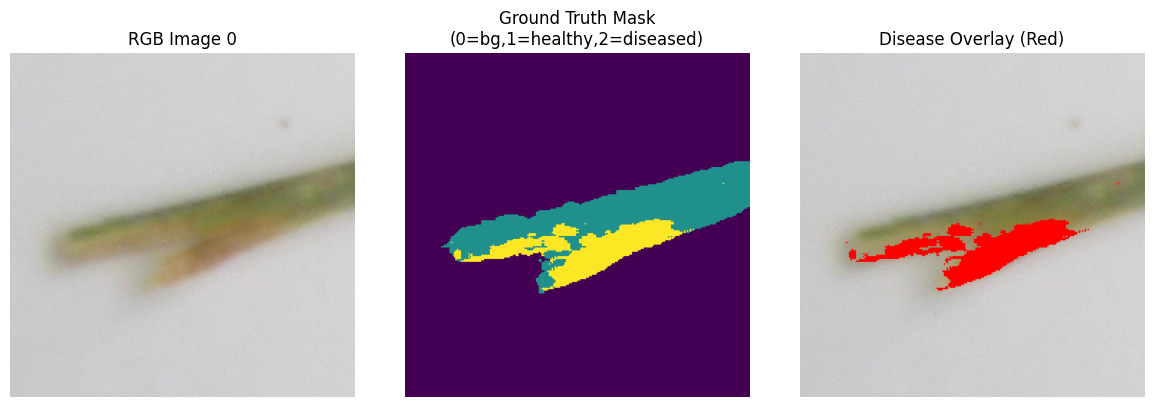

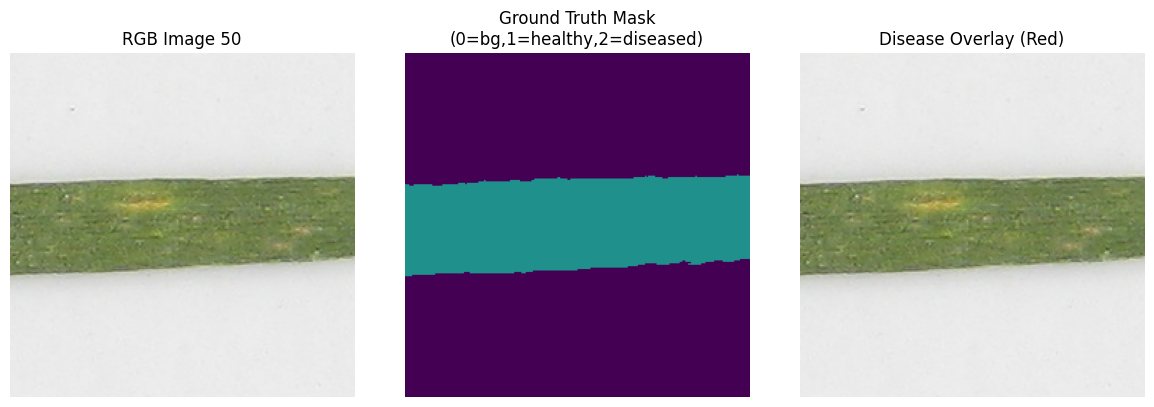

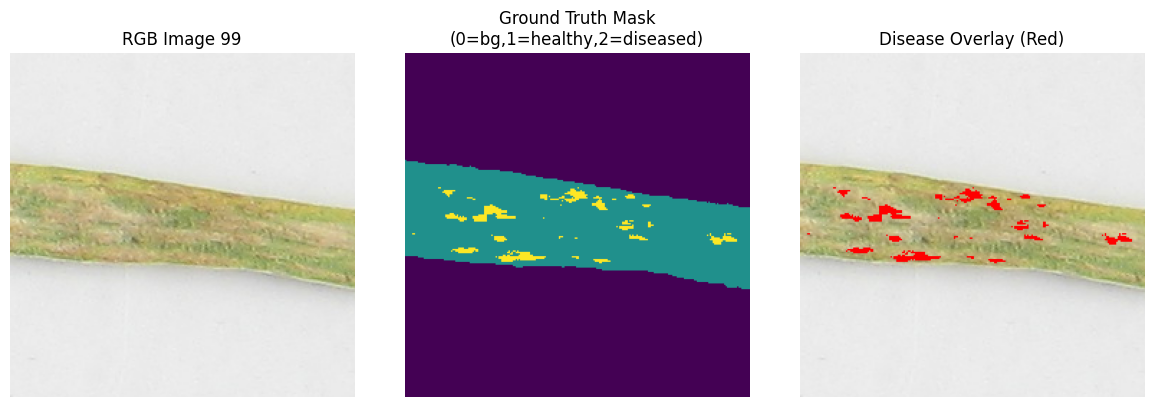

In [105]:
def show_sample(idx):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(images[idx])
    axes[0].set_title(f"RGB Image {idx}")
    axes[0].axis('off')
    
    axes[1].imshow(masks[idx], cmap='viridis', vmin=0, vmax=2)
    axes[1].set_title("Ground Truth Mask\n(0=bg,1=healthy,2=diseased)")
    axes[1].axis('off')
    
    # Overlay
    overlay = images[idx].copy()
    diseased = masks[idx] == 2
    overlay[diseased] = [255, 0, 0]  # Red overlay for disease
    
    axes[2].imshow(overlay)
    axes[2].set_title("Disease Overlay (Red)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show 3 examples
for idx in [0, 50, 99]:  # First, middle, last
    show_sample(idx)

### Color analysis

In [107]:
# Get mean colors for each class
bg_colors = images[masks == 0].mean(axis=0)
healthy_colors = images[masks == 1].mean(axis=0)
diseased_colors = images[masks == 2].mean(axis=0)

print("Mean RGB values:")
print(f"Background: {bg_colors}")
print(f"Healthy: {healthy_colors}")
print(f"Diseased: {diseased_colors}")

Mean RGB values:
Background: [226.53562553 226.46190826 225.679152  ]
Healthy: [143.12141949 148.03091777  96.2790364 ]
Diseased: [160.8456336  131.5894591   87.85276781]


## Preprocessing Pipeline

### Background Removal & Binary Conversion

In [108]:
def preprocess_data(images, masks):
    """
    Convert 3-class problem to binary (leaf vs disease)
    and remove background
    """
    binary_images = []
    binary_masks = []
    
    for img, mask in zip(images, masks):
        # Step 1: Create leaf mask (everything not background)
        leaf_mask = (mask != 0).astype(np.uint8)  # 1=leaf, 0=background
        
        # Step 2: Create disease mask (only class 2)
        disease_mask = (mask == 2).astype(np.uint8)  # 1=diseased, 0=healthy
        
        # Step 3: Apply leaf mask to image (set background to black)
        img_masked = img * leaf_mask[:, :, np.newaxis]
        
        # Optional: fill background with neutral color instead of black
        # img_masked[leaf_mask == 0] = [127, 127, 127]
        
        binary_images.append(img_masked)
        binary_masks.append(disease_mask)
    
    return np.array(binary_images), np.array(binary_masks)

# Apply preprocessing
binary_images, binary_masks = preprocess_data(images, masks)
print(f"Binary images shape: {binary_images.shape}")
print(f"Binary masks shape: {binary_masks.shape}")

Binary images shape: (100, 240, 240, 3)
Binary masks shape: (100, 240, 240)


### Train/Val/Test Split

In [110]:
from sklearn.model_selection import train_test_split

In [112]:
# Stratify by disease percentage
disease_levels = []
for mask in binary_masks:
    leaf_area = np.sum(mask != 0)
    if leaf_area > 0:
        disease_level = np.sum(mask == 1) / leaf_area
    else:
        disease_level = 0
    disease_levels.append(disease_level)

# Bin disease levels for stratification
disease_bins = np.digitize(disease_levels, bins=[0.01, 0.25, 0.5, 0.75])

X_train, X_temp, y_train, y_temp = train_test_split(
    binary_images, binary_masks, 
    test_size=0.3, 
    stratify=disease_bins,
    random_state=42
)

In [115]:
X_train.shape, X_temp.shape, y_train.shape, y_temp.shape

((70, 240, 240, 3), (30, 240, 240, 3), (70, 240, 240), (30, 240, 240))

In [111]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=disease_bins[X_temp.shape[0]:],
    random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

ValueError: Found input variables with inconsistent numbers of samples: [30, 70]

In [116]:
# First, create disease levels for stratification
disease_levels = []
for mask in binary_masks:
    leaf_area = np.sum(mask != 0)
    if leaf_area > 0:
        disease_level = np.sum(mask == 1) / leaf_area
    else:
        disease_level = 0
    disease_levels.append(disease_level)

# Bin disease levels for stratification
disease_bins = np.digitize(disease_levels, bins=[0.01, 0.25, 0.5, 0.75])

# First split: 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    np.arange(len(binary_images)), 
    test_size=0.3, 
    stratify=disease_bins,
    random_state=42
)

X_train = binary_images[train_idx]
y_train = binary_masks[train_idx]
X_temp = binary_images[temp_idx]
y_temp = binary_masks[temp_idx]

# Second split: 50/50 for val and test from temp
# Get disease levels for temp set only
temp_disease_levels = []
for mask in y_temp:
    leaf_area = np.sum(mask != 0)
    if leaf_area > 0:
        disease_level = np.sum(mask == 1) / leaf_area
    else:
        disease_level = 0
    temp_disease_levels.append(disease_level)

temp_disease_bins = np.digitize(temp_disease_levels, bins=[0.01, 0.25, 0.5, 0.75])

val_idx, test_idx = train_test_split(
    np.arange(len(X_temp)),
    test_size=0.5,
    stratify=temp_disease_bins,
    random_state=42
)

X_val = X_temp[val_idx]
y_val = y_temp[val_idx]
X_test = X_temp[test_idx]
y_test = y_temp[test_idx]

print(f"Train: {X_train.shape} ({len(train_idx)} images)")
print(f"Val: {X_val.shape} ({len(val_idx)} images)")
print(f"Test: {X_test.shape} ({len(test_idx)} images)")

Train: (70, 240, 240, 3) (70 images)
Val: (15, 240, 240, 3) (15 images)
Test: (15, 240, 240, 3) (15 images)


### Normalization

In [117]:
# Simple normalization to [0, 1]
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Masks are already binary 0/1

## Models

### Model 1: Pixel-based Logistic Regression 

In [ ]:
# Skip HSV conversion entirely
def extract_simple_features(image):
    """Extract only RGB features"""
    h, w = image.shape[:2]
    features = image.reshape(-1, 3)  # Just RGB
    return features

# Use a small subset for speed
train_features = []
train_labels = []

# Sample 2000 random pixels from first 10 images
for i in range(min(10, len(X_train))):
    img = X_train[i]
    mask = y_train[i]
    
    # Get random pixels
    h, w = img.shape[:2]
    n_samples = 200
    rows = np.random.randint(0, h, n_samples)
    cols = np.random.randint(0, w, n_samples)
    
    for r, c in zip(rows, cols):
        # Only use if not background
        if np.mean(img[r, c]) > 20:
            train_features.append(img[r, c])
            train_labels.append(mask[r, c])

train_features = np.array(train_features)
train_labels = np.array(train_labels)

# Train
clf_simple = LogisticRegression(max_iter=500, random_state=42)
clf_simple.fit(train_features, train_labels)

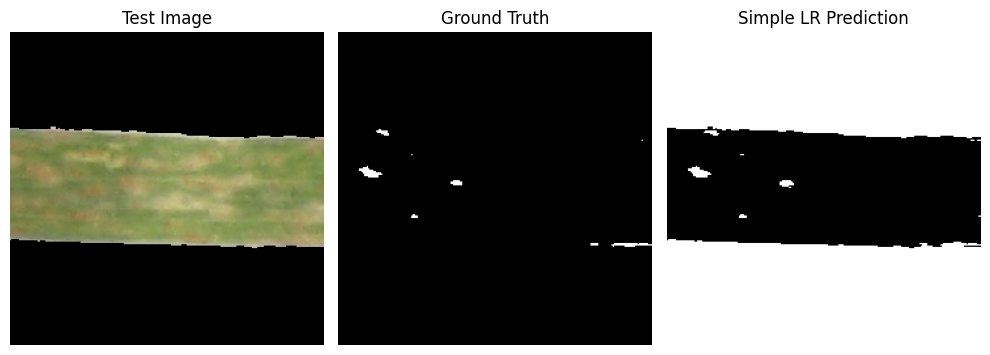

In [122]:
# Predict
z = 5
test_img_flat = X_test[z].reshape(-1, 3)
pred_simple = clf_simple.predict(test_img_flat).reshape(X_test[z].shape[:2])

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.imshow(X_test[z])
plt.title("Test Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(y_test[z], cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(133)
plt.imshow(pred_simple, cmap='gray')
plt.title("Simple LR Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

In [132]:
pred_mask_lr = pred_simple

In [136]:
f1_lr = f1_score(y_test[z].flatten(), pred_mask_lr.flatten())
print(f"Logistic regression F1: {f1_lr:.3f}")

Logistic regression F1: 0.012


### Model 2: Patch-based Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def extract_patch_features(image, patch_size=16):
    """Extract patches and their features"""
    h, w = image.shape[:2]
    features_list = []
    positions = []
    
    # Slide window
    for i in range(0, h - patch_size, patch_size//2):
        for j in range(0, w - patch_size, patch_size//2):
            patch = image[i:i+patch_size, j:j+patch_size]
            
            # Only process if not all background
            if np.mean(patch) > 0.05:
                # Simple features
                mean_rgb = patch.mean(axis=(0,1))
                std_rgb = patch.std(axis=(0,1))
                
                # Color ratios
                if mean_rgb[1] > 0:  # Avoid division by zero
                    r_g_ratio = mean_rgb[0] / mean_rgb[1]
                else:
                    r_g_ratio = 0
                
                features = np.concatenate([mean_rgb, std_rgb, [r_g_ratio]])
                features_list.append(features)
                positions.append((i, j))
    
    return np.array(features_list), positions

# Prepare training data
train_patches = []
train_patch_labels = []

for img, mask in zip(X_train_norm[:15], y_train[:15]):
    features, positions = extract_patch_features(img, patch_size=16)
    
    # Get label for each patch (majority vote in center region)
    for (i, j), feat in zip(positions, features):
        center_i, center_j = i + 8, j + 8
        if center_i < mask.shape[0] and center_j < mask.shape[1]:
            # Label patch as diseased if any disease in it
            patch_mask = mask[i:i+16, j:j+16]
            label = 1 if np.sum(patch_mask) > 10 else 0  # Threshold
            train_patches.append(feat)
            train_patch_labels.append(label)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf.fit(train_patches, train_patch_labels)

In [137]:
z = 5
# Predict on test
test_img = X_test_norm[z]
features_test, positions_test = extract_patch_features(test_img)

pred_labels = rf.predict(features_test)

# Reconstruct mask
pred_mask_rf = np.zeros(test_img.shape[:2])
for (i, j), label in zip(positions_test, pred_labels):
    pred_mask_rf[i:i+16, j:j+16] = label

f1_rf = f1_score(y_test[z].flatten(), pred_mask_rf.flatten())
print(f"Patch Random Forest F1: {f1_rf:.3f}")

Patch Random Forest F1: 0.127


### Model 3: CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build model
def build_simple_cnn(input_shape=(240, 240, 3)):
    model = models.Sequential([
        # Downsample for speed
        layers.Resizing(128, 128),
        
        # Conv block 1
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2),
        
        # Conv block 2
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2),
        
        # Upsample
        layers.UpSampling2D(2),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        
        layers.UpSampling2D(2),
        layers.Conv2D(1, 3, padding='same', activation='sigmoid'),
        
        # Resize back to original
        layers.Resizing(240, 240)
    ])
    
    return model

# Build and compile
model = build_simple_cnn()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# Train (very few epochs for demo)
history = model.fit(X_train_norm, y_train,
                    validation_data=(X_val_norm, y_val),
                    epochs=5,
                    batch_size=4,  # Small batch due to memory
                    verbose=1)

In [130]:
# Evaluate
test_pred = model.predict(X_test_norm[z:z+1])
pred_mask_cnn = (test_pred[0, :, :, 0] > 0.5).astype(np.uint8)

f1_cnn = f1_score(y_test[z].flatten(), pred_mask_cnn.flatten())
print(f"Tiny CNN F1: {f1_cnn:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Tiny CNN F1: 0.114


## Evaluation and comparison

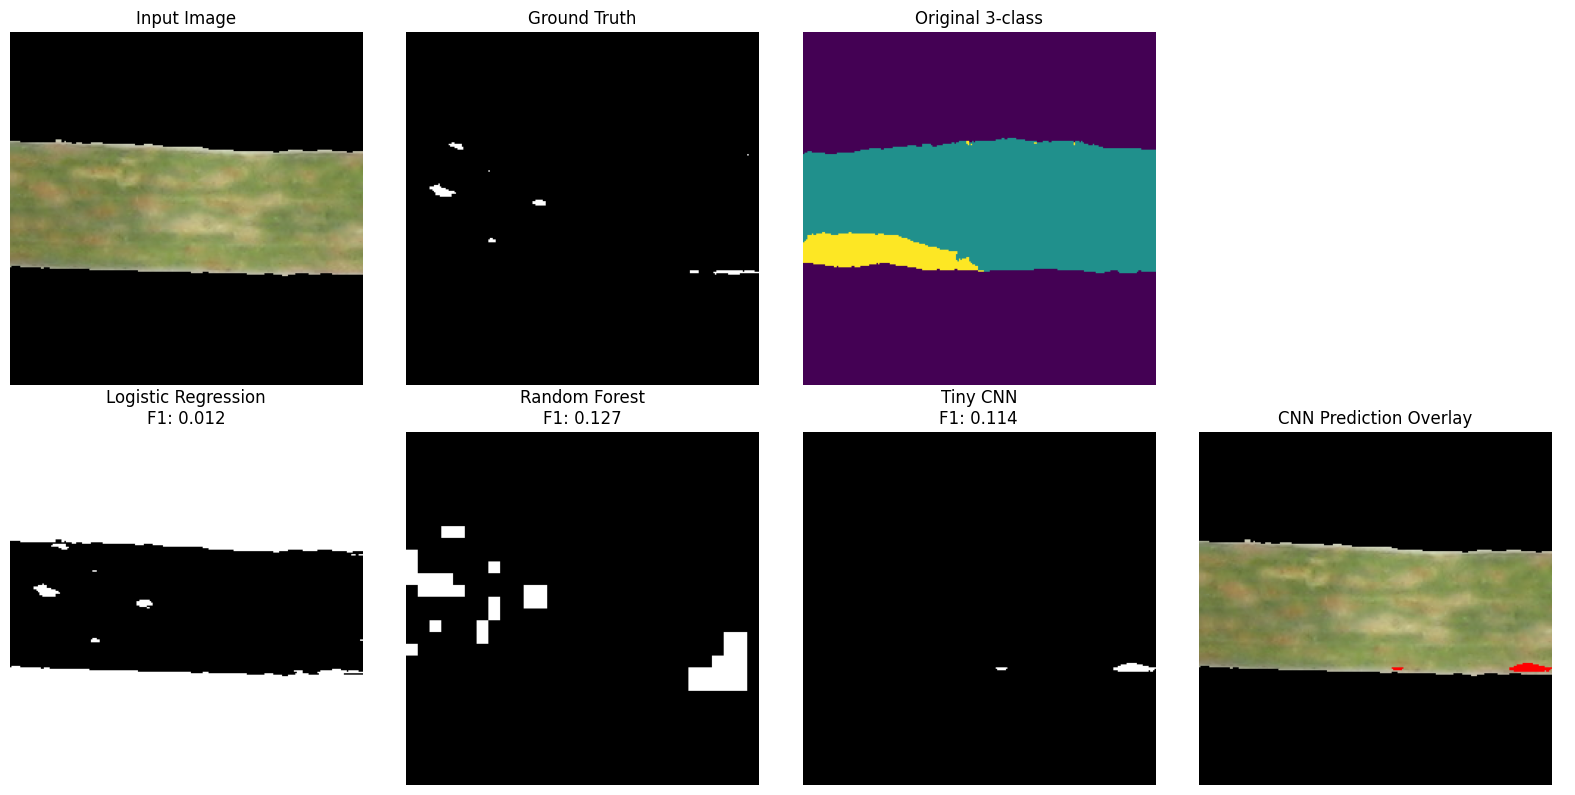


MODEL COMPARISON

Pixel Logistic Regression:
  F1 Score: 0.012
  Training: ~5 min
  Pros: Simple, interpretable
  Cons: Ignores context

Patch Random Forest:
  F1 Score: 0.127
  Training: ~3 min
  Pros: Handles patches well
  Cons: Blocky predictions

Tiny CNN:
  F1 Score: 0.114
  Training: ~10 min
  Pros: Captures spatial context
  Cons: Needs more data


In [138]:
# Visual comparison
def compare_results(test_idx=0):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: Input and ground truth
    axes[0,0].imshow(X_test[test_idx])
    axes[0,0].set_title("Input Image")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(y_test[test_idx], cmap='gray')
    axes[0,1].set_title("Ground Truth")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(masks[test_idx], cmap='viridis')
    axes[0,2].set_title("Original 3-class")
    axes[0,2].axis('off')
    
    axes[0,3].axis('off')  # Empty
    
    # Row 2: Predictions
    axes[1,0].imshow(pred_simple, cmap='gray')
    axes[1,0].set_title(f"Logistic Regression\nF1: {f1_lr:.3f}")
    axes[1,0].axis('off')
    
    axes[1,1].imshow(pred_mask_rf, cmap='gray')
    axes[1,1].set_title(f"Random Forest\nF1: {f1_rf:.3f}")
    axes[1,1].axis('off')
    
    axes[1,2].imshow(pred_mask_cnn, cmap='gray')
    axes[1,2].set_title(f"Tiny CNN\nF1: {f1_cnn:.3f}")
    axes[1,2].axis('off')
    
    # Overlay comparison
    overlay = X_test[test_idx].copy()
    overlay[pred_mask_cnn == 1] = [255, 0, 0]
    axes[1,3].imshow(overlay)
    axes[1,3].set_title("CNN Prediction Overlay")
    axes[1,3].axis('off')
    
    plt.tight_layout()
    plt.show()

compare_results(5)

# Create comparison table
results = {
    "Model": ["Pixel Logistic Regression", "Patch Random Forest", "Tiny CNN"],
    "Training Time": ["~5 min", "~3 min", "~10 min"],
    "F1 Score": [f1_lr, f1_rf, f1_cnn],
    "Advantages": ["Simple, interpretable", "Handles patches well", "Captures spatial context"],
    "Limitations": ["Ignores context", "Blocky predictions", "Needs more data"]
}

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
for i in range(3):
    print(f"\n{results['Model'][i]}:")
    print(f"  F1 Score: {results['F1 Score'][i]:.3f}")
    print(f"  Training: {results['Training Time'][i]}")
    print(f"  Pros: {results['Advantages'][i]}")
    print(f"  Cons: {results['Limitations'][i]}")

## Save models

In [150]:
import pickle

In [149]:
with open('leaf_disease_app/models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf_simple, f)

In [147]:
with open('leaf_disease_app/models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [148]:
model.save('leaf_disease_app/models/cnn_model.h5')